#  Get all required libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import cross_validation
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.genmod.families import family, links

# Shutdown warning prompts
import warnings
warnings.filterwarnings("ignore")
# to enable warnings: warnings.filterwarnings('always')

/home/akash/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Split data into train and test and print list of all columns and  list of columns containing NaN values

In [3]:
trainfull_df = pd.read_csv("Train.csv")
testfull_df = pd.read_csv("Test.csv")

columns_list = testfull_df.columns.tolist()
columns_list = trainfull_df.columns.tolist()
print("Columns list: "+str(columns_list))

nan_columns = testfull_df.columns[pd.isnull(testfull_df).any()].tolist()
print("Columns containing NaN values: "+str(nan_columns))

Columns list: ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']
Columns containing NaN values: ['Item_Weight', 'Outlet_Size']


# Describe train dataset

In [4]:
print(trainfull_df.describe(include="all"))

       Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
count             8523  7060.000000             8523      8523.000000   
unique            1559          NaN                5              NaN   
top              FDG33          NaN          Low Fat              NaN   
freq                10          NaN             5089              NaN   
mean               NaN    12.857645              NaN         0.066132   
std                NaN     4.643456              NaN         0.051598   
min                NaN     4.555000              NaN         0.000000   
25%                NaN          NaN              NaN         0.026989   
50%                NaN          NaN              NaN         0.053931   
75%                NaN          NaN              NaN         0.094585   
max                NaN    21.350000              NaN         0.328391   

                    Item_Type     Item_MRP Outlet_Identifier  \
count                    8523  8523.000000              852

# Describe test dataset

In [5]:
print(testfull_df.describe(include="all"))

       Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
count             5681  4705.000000             5681      5681.000000   
unique            1543          NaN                5              NaN   
top              NCS41          NaN          Low Fat              NaN   
freq                 8          NaN             3396              NaN   
mean               NaN    12.695633              NaN         0.065684   
std                NaN     4.664849              NaN         0.051252   
min                NaN     4.555000              NaN         0.000000   
25%                NaN          NaN              NaN         0.027047   
50%                NaN          NaN              NaN         0.054154   
75%                NaN          NaN              NaN         0.093463   
max                NaN    21.350000              NaN         0.323637   

          Item_Type     Item_MRP Outlet_Identifier  Outlet_Establishment_Year  \
count          5681  5681.000000          

# Performing data cleaning, some transformations(adding dummy variables and normalisation) to both train and test sets

In [6]:
def clean_and_normalise(df):
    # ===== list of items and stores
    stores_train = np.sort(df['Outlet_Identifier'].unique())
    items_train = np.sort(df['Item_Identifier'].unique())

    # ===== remove all rows having all columns as NaN
    df = df.dropna(how='all')
    r,c = df.shape
    # replace nan on Item weight and Outlet size
    df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].median())
    df['Outlet_Size'] = df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0])

    # ===== Normalise Item_Fat_Content to lowercase and then to dummy variables
    df['Item_Fat_Content'] = df['Item_Fat_Content'].str.lower()
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['lf'], 'low fat')
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['reg'], 'regular')
    df['Item_Fat_Content_Numeric'] = df['Item_Fat_Content'].map({'low fat' : 0, 'regular' : 1})

    # ===== Add dummy variable Outlet_Size_Numeric column
    # print(df['Outlet_Size'].unique())
    df['Outlet_Size_Numeric'] = df['Outlet_Size'].map({'Small' : 1, 'Medium' : 2, 'High' : 3})

    # ===== Add dummy variable Outlet_Location_Type_Numeric column
    # print(df['Outlet_Location_Type'].unique())
    df['Outlet_Location_Type_Numeric'] = df['Outlet_Location_Type'].map(
        {'Tier 1' : 1, 'Tier 2' : 2, 'Tier 3' : 3})

    # ===== Add dummy variable Outlet_Type_Numeric column
    # print(df['Outlet_Type'].unique())
    df['Outlet_Type_Numeric'] = df['Outlet_Type'].map(
        {'Supermarket Type1' : 1, 'Supermarket Type2' : 2, 'Supermarket Type3' : 3, 'Grocery Store' : 4})

    # ===== Add dummy variable Item_Type_Numeric column
    item_type_list = list(trainfull_df['Item_Type'].unique())
    # print(item_type_list)
    df['Item_Type_Numeric'] = [0]*r #initialise column with zeros to specify integers

    for i in range(r):
        itemtype = str(df['Item_Type'].loc[i])
        df['Item_Type_Numeric'].set_value(i, item_type_list.index(itemtype))
    
    # ===== Normalise Outlet_Establishment_Year
    est_year_list = list(df['Outlet_Establishment_Year'].unique())
    # print(est_year_list)
    df['Age'] = [0]*r      #initialise column with zeros to specify integers

    for i in range(r):
        curryear = df['Outlet_Establishment_Year'].loc[i]
        df['Age'].set_value(i, (2013-curryear))
    
    # ==== Adding new dummy variable MRP_Low_High column
    mrp_low_high = []
    for i in range(df.shape[0]):
        curr_mrp = df['Item_MRP'].loc[i]
        if(curr_mrp <= 69):
            mrp_low_high.append(0)
        elif(curr_mrp <= 136):
            mrp_low_high.append(1)
        elif(curr_mrp <= 203):
            mrp_low_high.append(2)
        else:
            mrp_low_high.append(3)
    df['MRP_Low_High'] = mrp_low_high
    
    # ==== Adding new dummy variable Item_Visibility_New column
    max_visi = df['Item_Visibility'].max()
    min_visi = df['Item_Visibility'].min()
    qrt_visi = (max_visi + min_visi)/4
    visi_low_high = []
    for i in range(df.shape[0]):
        curr_value = df['Item_Visibility'].loc[i]
        if(curr_value <= qrt_visi):
            visi_low_high.append(0)
        elif(curr_value <= (qrt_visi*2)):
            visi_low_high.append(1)
        elif(curr_value <= (qrt_visi*3)):
            visi_low_high.append(2)
        else:
            visi_low_high.append(3)
    df['Item_Visibility_New'] = visi_low_high
    
    # ==== Outlet_Location_Type and Item_Fat_Content combined column
    loctype = ['Tier 1', 'low fat', 'Tier 2', 'Tier 3', ]
    itemfat = ['low fat', 'regular']
    loctype_itemfat=[['Tier 1', 'low fat'], ['Tier 1', 'regular']
                     , ['Tier 2', 'low fat'], ['Tier 2', 'regular']
                     , ['Tier 3', 'low fat'], ['Tier 3', 'regular']]
    df['Loctype_Itemfat'] = [0]*r
    for i in range(r):
        currlocctype = df['Outlet_Location_Type'].loc[i]
        curritemfat = df['Item_Fat_Content'].loc[i]
        df['Loctype_Itemfat'].set_value(i, loctype_itemfat.index([currlocctype, curritemfat]))
    
    return df



trainfull_df = clean_and_normalise(trainfull_df)
testfull_df = clean_and_normalise(testfull_df)

# Data types of each column

In [7]:
print(" ===== TRAIN =====\n"+str(trainfull_df.dtypes))
print("\n ===== TEST =====\n"+str(testfull_df.dtypes))


 ===== TRAIN =====
Item_Identifier                  object
Item_Weight                     float64
Item_Fat_Content                 object
Item_Visibility                 float64
Item_Type                        object
Item_MRP                        float64
Outlet_Identifier                object
Outlet_Establishment_Year         int64
Outlet_Size                      object
Outlet_Location_Type             object
Outlet_Type                      object
Item_Outlet_Sales               float64
Item_Fat_Content_Numeric          int64
Outlet_Size_Numeric               int64
Outlet_Location_Type_Numeric      int64
Outlet_Type_Numeric               int64
Item_Type_Numeric                 int64
Age                               int64
MRP_Low_High                      int64
Item_Visibility_New               int64
Loctype_Itemfat                   int64
dtype: object

 ===== TEST =====
Item_Identifier                  object
Item_Weight                     float64
Item_Fat_Content            

# Plotting some graphs
## *Outlet_Size* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

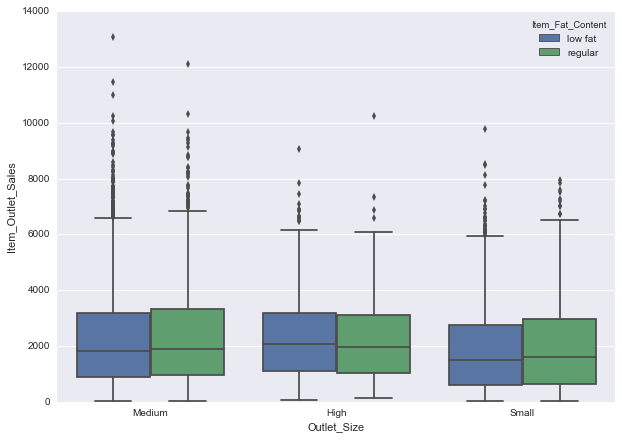

In [8]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data = trainfull_df, hue="Item_Fat_Content")

## *Outlet_Location_Type* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

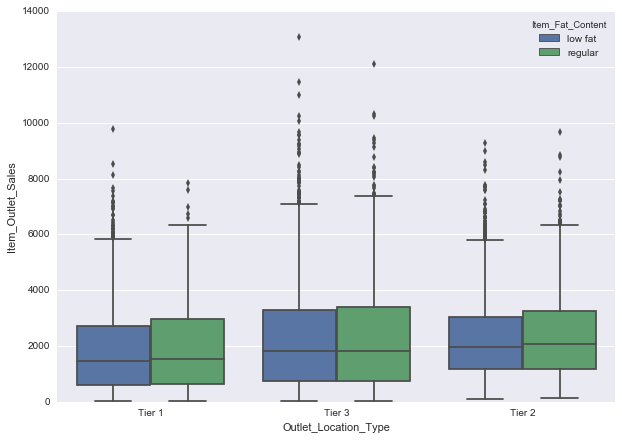

In [9]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data = trainfull_df, hue="Item_Fat_Content")

## *Outlet_Type* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

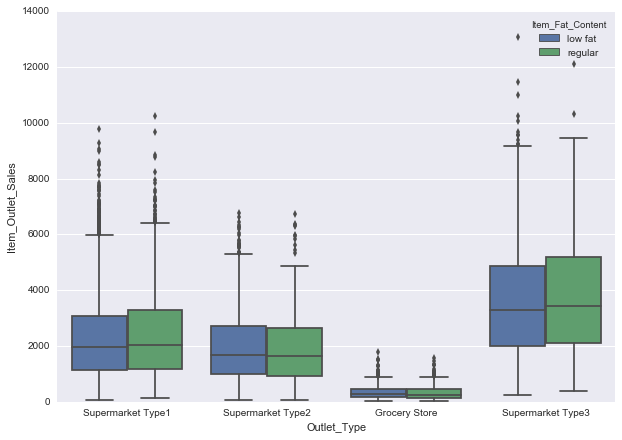

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data = trainfull_df, hue="Item_Fat_Content")

## Correlation Heatmap

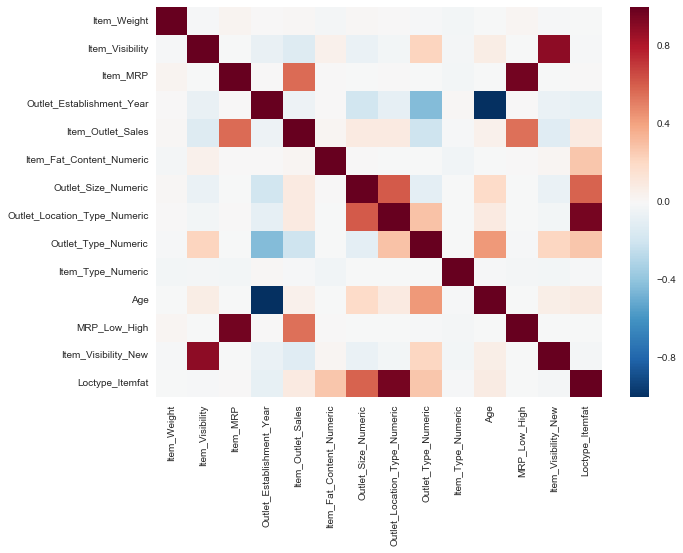

In [11]:
plt.figure(figsize=(10,7))
sns.heatmap(trainfull_df.corr())

In [12]:
features2 = [
    'Outlet_Type_Numeric', 'Item_MRP', 'Outlet_Size_Numeric', 'Outlet_Location_Type_Numeric', 'MRP_Low_High'
    , 'Item_Type_Numeric', 'Item_Visibility', 'Item_Weight', 'Item_Fat_Content_Numeric', 'Age'
    , 'Loctype_Itemfat'#, 'Item_Visibility_New'
            ]

features = [
    'Item_MRP', 'Outlet_Type_Numeric', 'Outlet_Location_Type_Numeric', 'Age', 'Loctype_Itemfat'
    ,  'Outlet_Size_Numeric', 'Item_Type_Numeric', 'Item_Visibility'#, 'MRP_Low_High'
    , 'Item_Fat_Content_Numeric'#, 'Item_Visibility_New', 'Item_Weight'
            ]

## Plotting feature importance graph using XGB's *plot_importance*

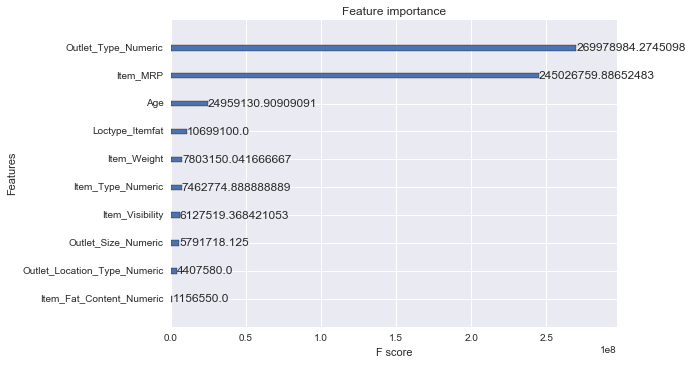

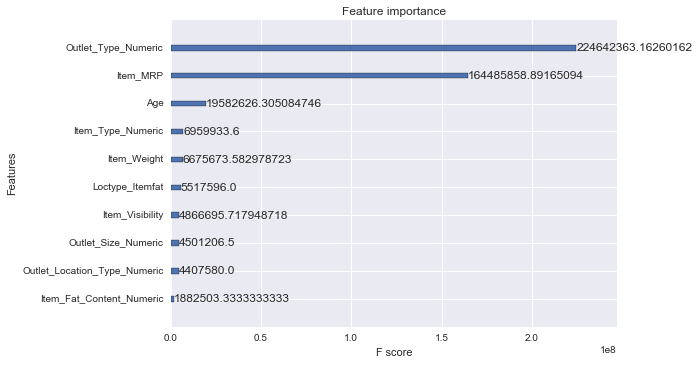

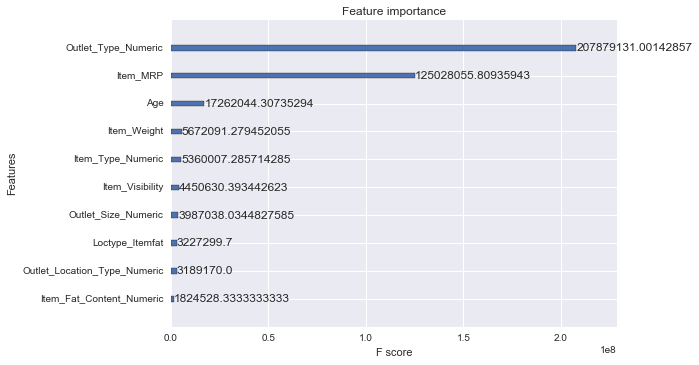

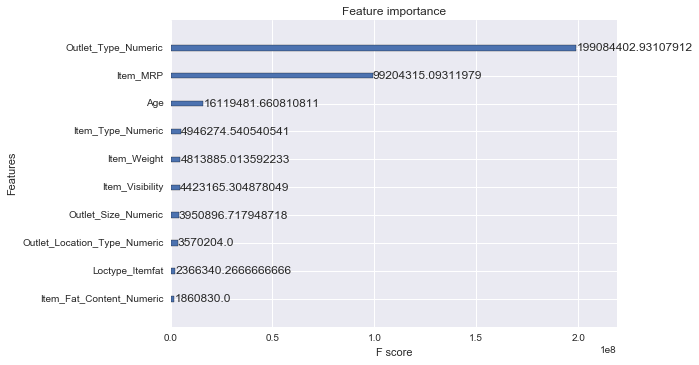

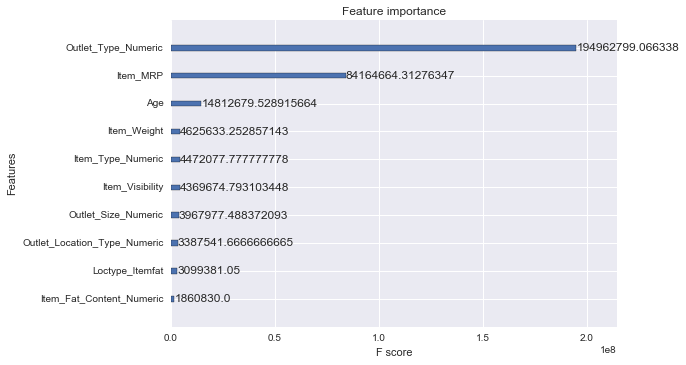

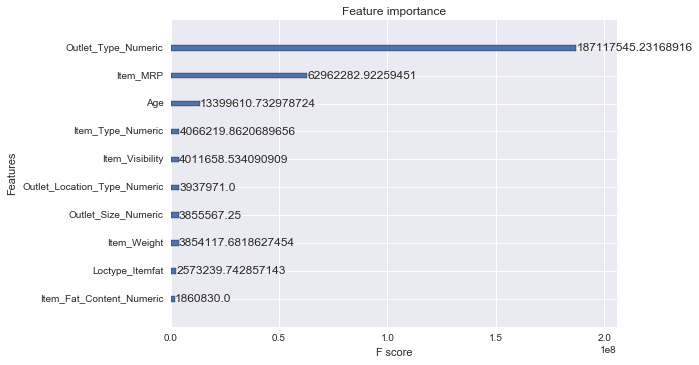

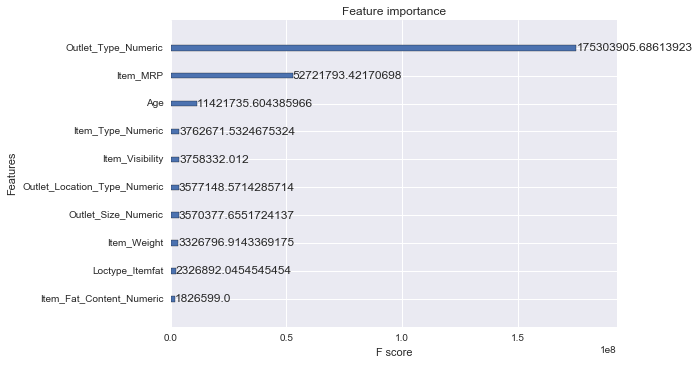

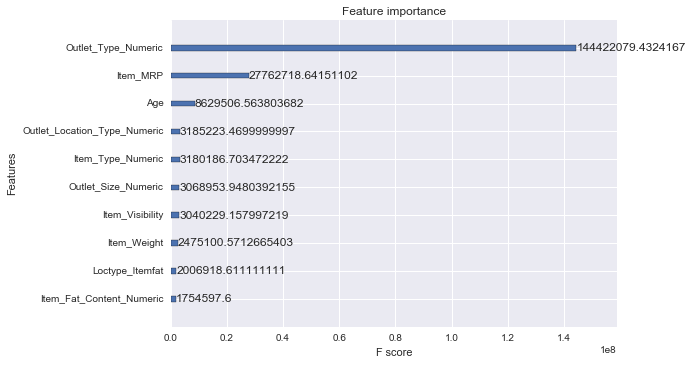

In [13]:
train = trainfull_df[:int(trainfull_df.shape[0]*0.8)]
# print(train)
test = trainfull_df[int(trainfull_df.shape[0]*0.8):]
# print(test)

estimators = [50, 75, 100, 125, 150, 200, 250, 500]
for e in estimators:
    xg = xgb.XGBRegressor(n_estimators = e)
    
#     plt.figure(figsize=(10,10))
    xg.fit(train[features2], train['Item_Outlet_Sales'])
    xgb.plot_importance(xg, importance_type='gain')#, ax=ax1)


# Determining which of *RandomForestRegressor* or *GradientBoostingRegressor* or *XGBRegressor* will have minimum RMSE Error

In [14]:
def prediction_function(train, test):
    estimators = [50, 75, 80, 100, 125, 150, 200, 250, 500]

    final = []

    for e in estimators:
        rf = RandomForestRegressor(random_state = 1, n_estimators = e, min_samples_split = 8, min_samples_leaf = 4)
        gbr = GradientBoostingRegressor(random_state = 1, n_estimators = e, min_samples_split = 8, 
                                        min_samples_leaf = 4, learning_rate = 0.1)
        xg = xgb.XGBRegressor(n_estimators = e)

        rf.fit(train[features], train['Item_Outlet_Sales'])
        predictions_rf = rf.predict(test[features])
        predictions_rf = predictions_rf.astype(int)

        gbr.fit(train[features], train['Item_Outlet_Sales'])
        predictions_gbr = gbr.predict(test[features])
        predictions_gbr = predictions_gbr.astype(int)

        xg.fit(train[features], train['Item_Outlet_Sales'])
        predictions_xg = xg.predict(test[features])
        predictions_xg = predictions_xg.astype(int)

        mse_rf = (np.sqrt(mean_squared_error(test['Item_Outlet_Sales'], predictions_rf)), 'RF')
        mse_gbr = (np.sqrt(mean_squared_error(test['Item_Outlet_Sales'], predictions_gbr)), 'GBR')
        mse_xg = (np.sqrt(mean_squared_error(test['Item_Outlet_Sales'], predictions_xg)), 'XGB')

        error_min = min(mse_rf, min(mse_gbr, mse_xg))
#         print(error_min)
        final.append((error_min, e))

    min_final = min(final)
    print("Minimum MSE, regressor to use and number of estimators: "+str(min_final))
    return list(min_final)

In [15]:
train = trainfull_df[:int(trainfull_df.shape[0]*0.8)]
test = trainfull_df[int(trainfull_df.shape[0]*0.8):]
min_final = prediction_function(train, test)

Minimum MSE, regressor to use and number of estimators: ((1083.9065669828547, 'XGB'), 100)


In [16]:
e_to_use = min_final[1]
regressor_to_use = min_final[0][1]
# print("Mimimum RMSE error was for "+str(regressor_to_use)+" with "+str(e_to_use)+" estimators")

if(regressor_to_use == 'RF'):
    reg = RandomForestRegressor(random_state = 1, n_estimators = e_to_use, min_samples_split = 8, min_samples_leaf = 4)
elif(regressor_to_use == 'GBR'):
    reg = GradientBoostingRegressor(random_state = 1, n_estimators = e_to_use, min_samples_split = 8, min_samples_leaf = 4, learning_rate = 0.1)
else:
    reg = xgb.XGBRegressor(n_estimators = e_to_use)

reg.fit(trainfull_df[features], trainfull_df['Item_Outlet_Sales'])
predictions = reg.predict(testfull_df[features])
predictions = predictions.astype(int)

# Writing final output to csv file *output.csv*

In [17]:
sub = pd.DataFrame({'Item_Identifier' : testfull_df['Item_Identifier'], 'Outlet_Identifier' : testfull_df['Outlet_Identifier'], 'Item_Outlet_Sales' : predictions})
sub.to_csv('./output.csv', index=False)